Dataset shape: (1503, 6)
   Frequency  Angle_of_Attack  Chord_Length  Free_Stream_Velocity  \
0        800              0.0        0.3048                  71.3   
1       1000              0.0        0.3048                  71.3   
2       1250              0.0        0.3048                  71.3   
3       1600              0.0        0.3048                  71.3   
4       2000              0.0        0.3048                  71.3   

   Suction_Side_Displacement_Thickness  Sound_Pressure_Level  
0                             0.002663               126.201  
1                             0.002663               125.201  
2                             0.002663               125.951  
3                             0.002663               127.591  
4                             0.002663               127.461  
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'C': 200, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
Test RMSE: 2.561
Test R²: 0.8691


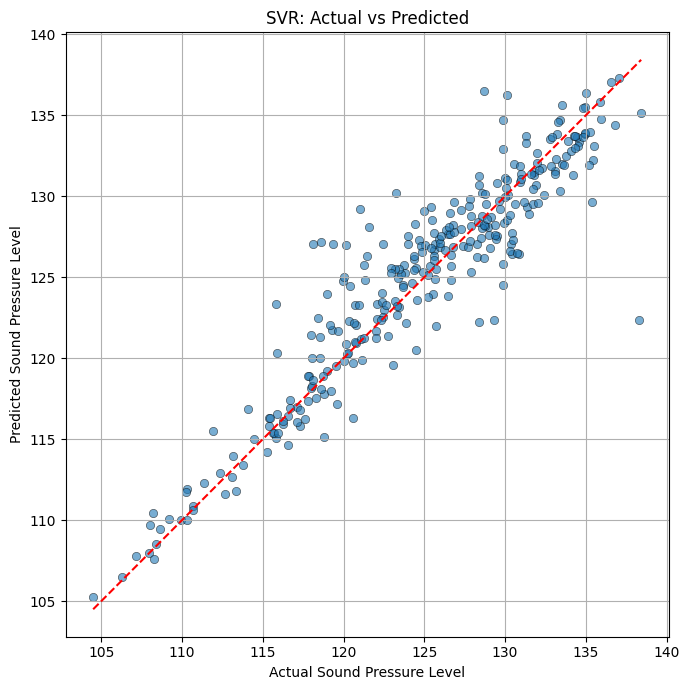

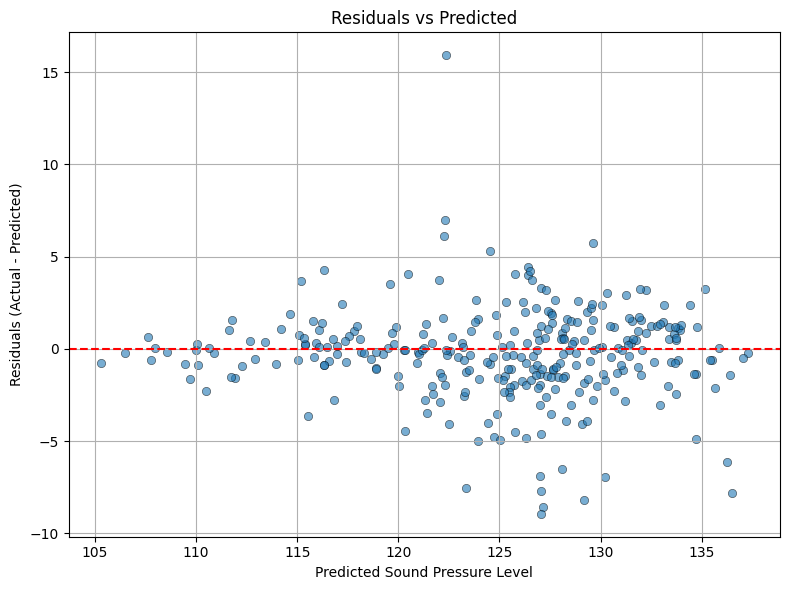

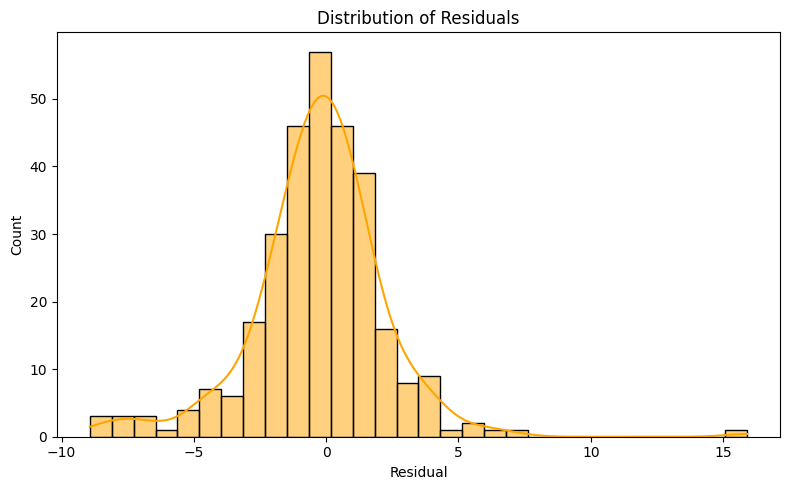

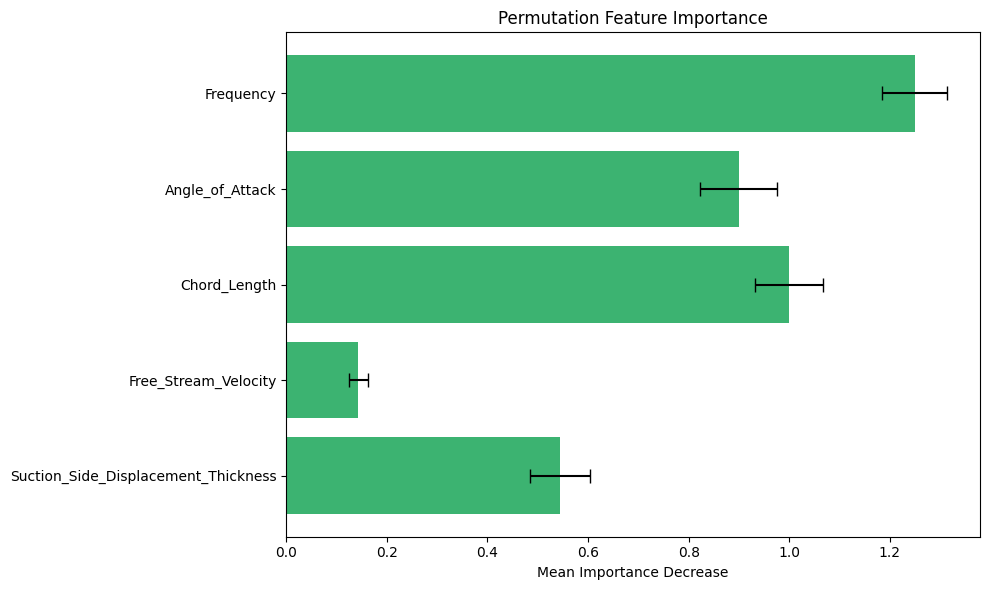

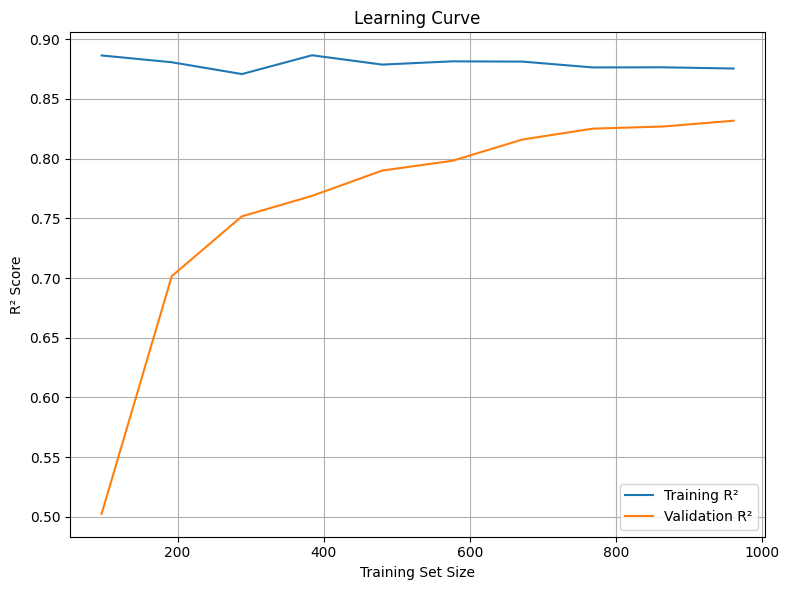

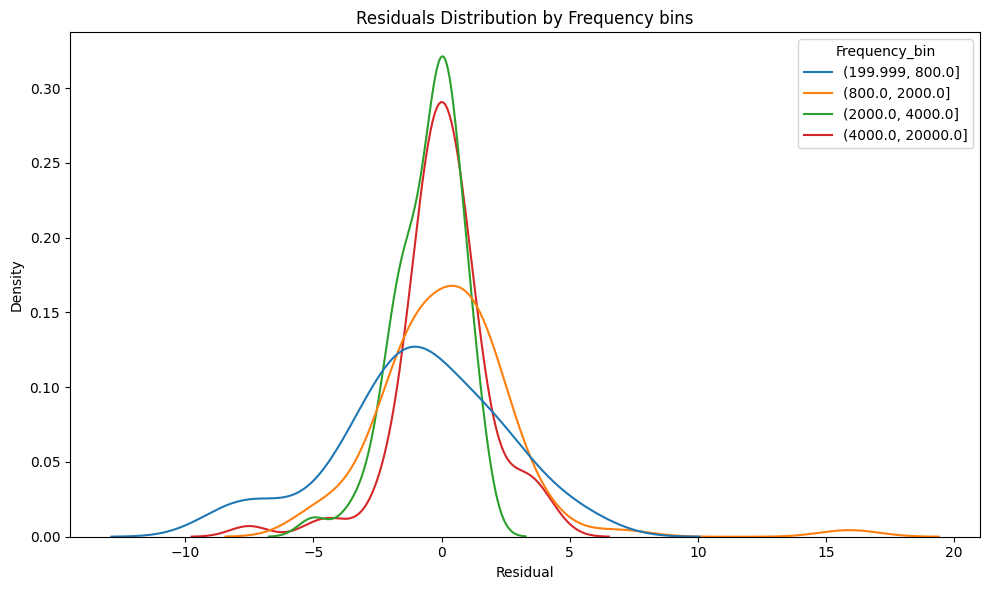

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay


# 1. Load dataset
column_names = ['Frequency', 'Angle_of_Attack', 'Chord_Length', 'Free_Stream_Velocity',
                'Suction_Side_Displacement_Thickness', 'Sound_Pressure_Level']
df = pd.read_csv("airfoil_self_noise.csv", sep='\t', header=None, names=column_names)

print("Dataset shape:", df.shape)
print(df.head())

# 2. Define features and target
X = df.drop('Sound_Pressure_Level', axis=1)
y = df['Sound_Pressure_Level']

# 3. Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. SVR with extended hyperparameter tuning using GridSearchCV
svr = SVR()

param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [1, 10, 50, 100, 200],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.2]  
}

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_svr = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# 6. Predict on test set
y_pred = best_svr.predict(X_test_scaled)

# 7. Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.4f}")

# 8. Visualizations

# 8a. Actual vs Predicted
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sound Pressure Level")
plt.ylabel("Predicted Sound Pressure Level")
plt.title("SVR: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8b. Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Sound Pressure Level")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8c. Residuals distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# 8d. Permutation Feature Importance (using matplotlib for error bars)
result = permutation_importance(best_svr, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

importances = result.importances_mean
stds = result.importances_std
features = X.columns

fig, ax = plt.subplots(figsize=(10,6))
y_pos = np.arange(len(features))
ax.barh(y_pos, importances, xerr=stds, align='center', color='mediumseagreen', ecolor='black', capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis() 
ax.set_xlabel("Mean Importance Decrease")
ax.set_title("Permutation Feature Importance")
plt.tight_layout()
plt.show()


# 8e. Learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    best_svr, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Training R²')
plt.plot(train_sizes, valid_mean, label='Validation R²')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 8f. Residual distribution by Frequency bins
df_test = X_test.copy()
df_test['Actual'] = y_test
df_test['Predicted'] = y_pred
df_test['Residual'] = residuals
df_test['Frequency_bin'] = pd.qcut(df_test['Frequency'], q=4)

plt.figure(figsize=(10,6))
sns.kdeplot(data=df_test, x='Residual', hue='Frequency_bin', common_norm=False)
plt.title("Residuals Distribution by Frequency bins")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()
